<img src="elkh_logo.svg" style="height: 51px; margin-right: 40px;" /> <img src="julich_logo.png"/>

# About

This notebook shows the implementation of the vertex cover problem using a local simulator, and the D-Wave quantum hardware. First a random Erdős-Rényi graph is generated, for which we calculate the vertex cover using both the local simulator, and the D-Wave hardware. As the next step, we generate graphs with increasing node numbers, and check the performance of the simulator and the real hardware.

The example builds on DWave's <a href="https://docs.ocean.dwavesys.com/en/stable/examples/min_vertex.html">Vertex Cover example</a>.

## Vertex cover problem

In graph theory, a vertex cover (sometimes node cover) of a graph is a set of vertices that includes at least one endpoint of every edge of the graph. In computer science, the problem of finding a minimum vertex cover is a classical optimization problem. See the <a href="https://en.wikipedia.org/wiki/Vertex_cover">Vertex Cover Wikipedia article</a> for details.

## Import necessary tools

First we need to import some libraries.

In [1]:
import dwave_networkx as dnx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import time
import sys
from dimod.reference.samplers import ExactSolver
from dwave.system import DWaveSampler, EmbeddingComposite

## Properties of the experiment

You can change the below parameters and re-run the notebook for experimenting:
* `NUM_NODES`: the number of nodes in the graph to be generated (e.g. `16`),
* `EDGE_PROB`: probability of edges between two nodes in the graph (e.g. `0.2`),
* `DWAVE_TOKEN`: must be set to the D-Wave Leap token of the user.

In [2]:
NUM_NODES = 16
EDGE_PROB = 0.2
DWAVE_TOKEN = ''

## Generating the graph

As already mentioned, we'll be generating a random Erdős-Rényi graph with `NUM_NODES` nodes, and with `EDGE_PROB` probability of edges between the nodes.

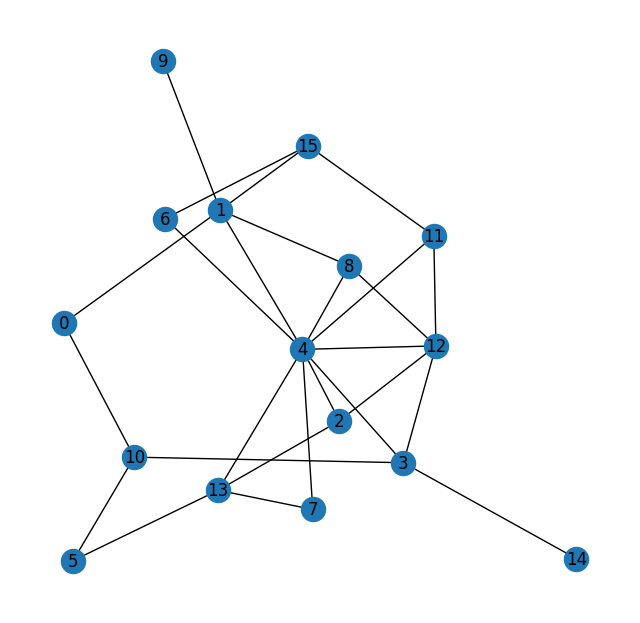

In [3]:
G = nx.erdos_renyi_graph(NUM_NODES, EDGE_PROB)
plt.clf()
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos)
ax = plt.gcf()
ax.set_size_inches(8, 8)
ax.set_dpi(100)
plt.axis("off")
plt.savefig('graph_%d.png' % NUM_NODES, bbox_inches='tight')

## Definition of samplers

DWave offers multiple samplers to perform a computation. They accept problems in different model formats, and use either local CPU, hybrid resources or QPU hardware to determine the best solution for the problem.

In this example, we're using two samplers: the <a href="https://docs.ocean.dwavesys.com/en/latest/docs_dimod/reference/sampler_composites/samplers.html#exact-solver">`ExactSolver()`</a> and the <a href="https://docs.ocean.dwavesys.com/en/stable/docs_system/reference/samplers.html#dwavesampler">`DWaveSampler()`</a>. The first uses the local CPU, while the second one uses the QPU to achieve a solution.

In [4]:
sampler_e = ExactSolver()
sampler_c = EmbeddingComposite(DWaveSampler(token=DWAVE_TOKEN))

## Helper function - run sampler on graph

This function can be used to determine the minimum vertex cover of a graph using a specified sampler. The return value of the function is a tuple: the number of seconds required for the computation, and the solution (lost of index of nodes participating in the minimum vertex cover).

In [5]:
# Run sampler on graph.
# Parameters:
#  - G: the graph
#  - sampler: the sampler to use
#  - pos: position of nodes
#  - draw: True or False (draw the graph or not)
def run_sampler(G, sampler, pos = None, draw = False):
    time_start = time.time()
    solution = dnx.min_vertex_cover(G, sampler, label='MinVertex %d' % G.number_of_nodes())
    time_end = time.time()
    total_time = time_end-time_start
    if draw:
        color_map = []
        for node in G:
            if node in solution:
                color_map.append('red')
            else:
                color_map.append('blue')
        plt.clf()
        nx.draw_networkx(G, pos=pos if pos is not None else nx.spring_layout(G), node_color=color_map)
        ax = plt.gcf()
        ax.set_size_inches(8, 8)
        ax.set_dpi(100)
        plt.axis("off")
    return (total_time, solution)

## Run samplers on our graph

Now we are ready to determine the minimum vertex cover of the above graph, using first the local CPU, next real quantum hardware.

Achieved solution in 0.090088 seconds using sampler ExactSolver: [1, 3, 4, 10, 12, 13, 15]


/usr/local/lib/python3.9/dist-packages/dimod/core/sampler.py:293: SamplerUnknownArgWarning: Ignoring unknown kwarg: 'label'
  return self.sample(bqm, **parameters)


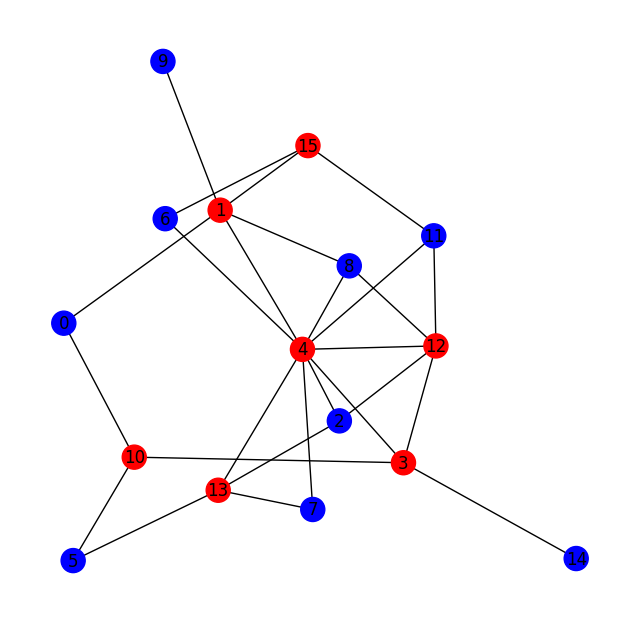

In [6]:
(time_e, solution_e) = run_sampler(G, sampler_e, pos, True)
print('Achieved solution in %f seconds using sampler ExactSolver: %r' % (time_e, solution_e))

Achieved solution in 7.775081 seconds using sampler DWaveSampler: [1, 4, 10, 12, 13, 14, 15]


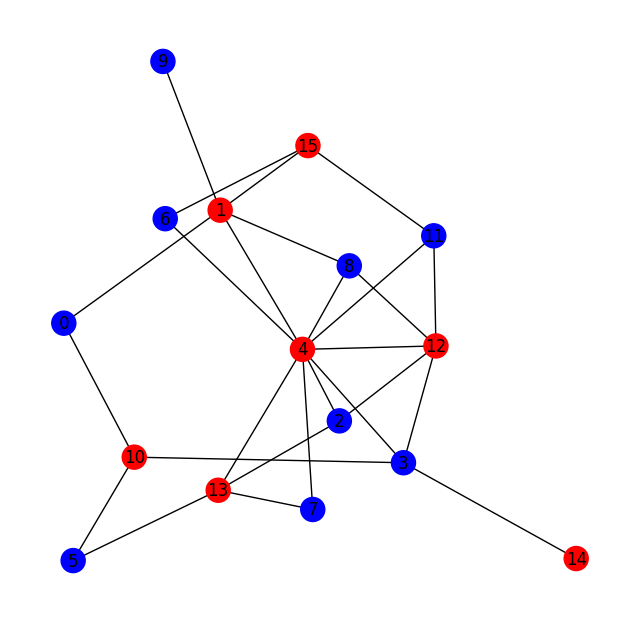

In [8]:
(time_c, solution_c) = run_sampler(G, sampler_c, pos, True)
print('Achieved solution in %f seconds using sampler DWaveSampler: %r' % (time_c, solution_c))

## Examine the results

Check the coloring of the two graphs. There can be multiple solutions for the minimum vertex cover problem in case of a graph, so it can happen, that the two samplers return different results. The `ExactSolver()` will return always the same results, while the `DWaveSampler()` may return different results due to the characteristics of the hardware.

You can run the above samplers multiple times, to check the colorings.

## Computation time

As you might have noticed, the `ExactSolver()` is way much faster, then the `DWaveSampler()` for the above-sized graph. In this part, we will see how processing times change with an increasing graph size. If the processing time for any of the solvers goes above one minute, we will stop calculations using that given solver.

Nodes    ExactSolver()   DWaveSampler() 
10          0.00295234       2.72062421
11          0.00249004       2.72625184
12          0.00449991       2.78969669
13          0.01132488       3.57211733
14          0.01940584       1.29480958
15          0.03389931       1.28083944
16          0.07991767       1.35369968
17          0.17309403       1.24907923
18          0.36646676       1.25109434
19          0.76352119       1.21032786
20          1.88158226       1.32314849
21          3.35995364       1.50365424
22          7.63358760       1.32360864
23         15.87069845       1.50218248
24         31.02192903       3.33071947
25         66.31770945       3.72862935
26             SKIPPED       3.51045394
27             SKIPPED       3.04316044
28             SKIPPED       3.33016062
29             SKIPPED       3.15979886


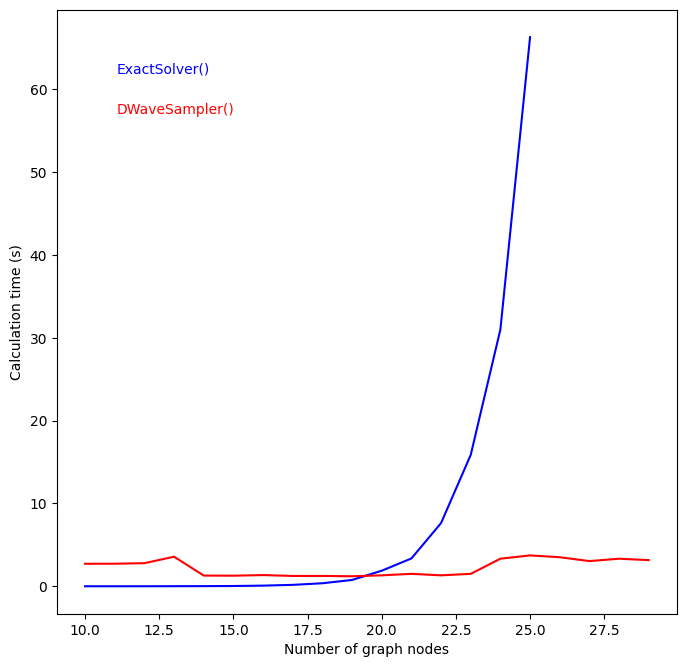

In [9]:
run_solvers = (True, True)
print('{:<8} {:<15} {:<15}'.format('Nodes', 'ExactSolver()', 'DWaveSampler()'))
ax_e = []
va_e = []
ax_c = []
va_c = []
for num_nodes in range(10, 30):
    Gn = nx.erdos_renyi_graph(num_nodes, EDGE_PROB)
    if run_solvers[0]:
        (time_e, solution_e) = run_sampler(Gn, sampler_e)
        time_e_str = '{:13.8f}'.format(time_e)
        ax_e.append(num_nodes)
        va_e.append(time_e)
    else:
        time_e_str = '      SKIPPED'
    if run_solvers[1]:
        (time_c, solution_c) = run_sampler(Gn, sampler_c)
        time_c_str = '{:15.8f}'.format(time_c)
        ax_c.append(num_nodes)
        va_c.append(time_c)
    else:
        time_c_str = '        SKIPPED'
    print('{:<8} {}  {}'.format(num_nodes, time_e_str, time_c_str))
    run_solvers = (time_e_str.strip() != 'SKIPPED' and time_e <= 60, time_c_str.strip() != 'SKIPPED' and time_c <= 60)
plt.clf()
plt.plot(ax_e, va_e, 'b', ax_c, va_c, 'r')
plt.xlabel('Number of graph nodes')
plt.ylabel('Calculation time (s)')
plt.figtext(0.2, 0.8, 'ExactSolver()', color='b')
plt.figtext(0.2, 0.75, 'DWaveSampler()', color='r')
ax = plt.gcf()
ax.set_size_inches(8, 8)
ax.set_dpi(100)